# Project 3: Deep Learning Models for Time-series Forecasting

#### Charlie Bailey (peba296)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

## Environment Setup

This project utilizes TensorFlow with GPU acceleration on Apple Silicon (M-series) hardware. Due to specific version requirements and GPU compatibility, the following setup is recommended:

#### Requirements
- Python 3.10.x (TensorFlow compatibility requirement)
- tensorflow-macos
- tensorflow-metal (for Apple Silicon GPU support)

In [2]:
# Confirm TensorFlow is correctly setup and has access to local GPUs for training
print(tf.__version__)
print("Local GPUs::: ", tf.config.list_physical_devices('GPU'))

# Set a tf random seed
tf.random.set_seed(42)

2.16.2
Local GPUs:::  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Project Introduction

The goal of this project is to forecast future Bitcoin (BTC) prices based on historical trading data. This is a time-series forecasting problem, which is well suited to a deep learning solution utilizing Recurrent Neural Networks (RNNs).

#### Motivation

I've been an investor in BTC for a while now, and with the currency recently crossing the $100k value point, I thought it would be interesting to try and forecast where the price will head from here. If this project ends up going well, I may even attempt to use this analysis to make some investment decisions!

From a personal growth standpoint, I also worked with mostly categorical data on my last two projects so I wanted to get some experience with continous data.

#### Data Source

The dataset for this project comes from Muhmmad Bilal Ramzan on Kaggle and provides daily BTC-USD trading data from 2014 to present. [Link to source.](https://www.kaggle.com/datasets/mianbilal12/bitcoin-historical-data)

## Phase 1: EDA

### Data Description

This dataset contains 3724 instances of historical Bitcoin trading data. The dataset has 7 features: `Date`, `Adj Close`, `Close`, `High`, `Low`, `Open`, and `Volume`.

Here is the full data dictionary:

| Variable Name | Role | Type | Description |
|---------------|------|------|-------------|
| Date | Feature | Continuous | Specific data of data entry |
| Adj Close | Feature | Continuous | Adjusted closing price account for any splits |
| Close | Target | Continuous | Closing price at end of trading day (USD) |
| High | Feature | Continuous | Highest price reached during trading day (USD) |
| Low | Feature | Continuous | Lowest price reached during trading day (USD) |
| Open | Feature | Continuous | Opening price at start of trading day (USD) |
| Volume | Feature | Continuous | Total value of BTC traded during trading day (USD) |

Note: after doing some digging, the original dataset describes the `Volume` variable as being "the total number of Bitcoins traded during the day," however in cross-referencing these numbers with other data sources, this is almost certainly incorrect as there are only 19,897,319 BTC in circulation. Therefore, the `Volume` is most likely in USD—which would align with the units of the rest of the variables.

In [3]:
df = pd.read_csv('./data/Bitcoin_Historical_Data.csv')
df.head(10)

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17 00:00:00+00:00,457.334015,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18 00:00:00+00:00,424.440002,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19 00:00:00+00:00,394.795990,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20 00:00:00+00:00,408.903992,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21 00:00:00+00:00,398.821014,398.821014,412.425995,393.181000,408.084991,26580100
5,2014-09-22 00:00:00+00:00,402.152008,402.152008,406.915985,397.130005,399.100006,24127600
6,2014-09-23 00:00:00+00:00,435.790985,435.790985,441.557007,396.196991,402.092010,45099500
7,2014-09-24 00:00:00+00:00,423.204987,423.204987,436.112000,421.131989,435.751007,30627700
8,2014-09-25 00:00:00+00:00,411.574005,411.574005,423.519989,409.467987,423.156006,26814400
9,2014-09-26 00:00:00+00:00,404.424988,404.424988,414.937988,400.009003,411.428986,21460800


### Cleaning

We will first check for any `null` or missing values. Since RNNs process sequential data, we need to ensure there aren't any missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3724 entries, 0 to 3723
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3724 non-null   object 
 1   Adj Close  3724 non-null   float64
 2   Close      3724 non-null   float64
 3   High       3724 non-null   float64
 4   Low        3724 non-null   float64
 5   Open       3724 non-null   float64
 6   Volume     3724 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 203.8+ KB


In [5]:
# Check for missing values
print(df.isnull().sum())

Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


Next, we'll look at the correlation between the trading variables. My hypothesis is that `Adj Close`, `Close`, `High`, `Low`, `Open` will all be highly correlated since these are all just point-in-time instances of the same underlying price metric. In fact, it looks like `Close` and `Adj Close` may be the same (since BTC doesn't have any splits)—but lets confirm before dropping.

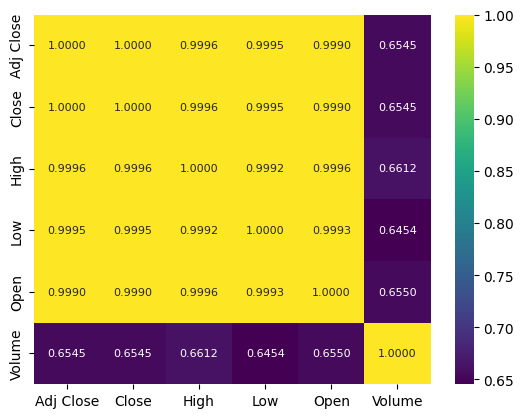

In [6]:
# Correlation Matrix
corr_matrix = df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="viridis", fmt=".4f", annot_kws={"size": 8})
plt.show()

As we can see here, my hypothesis is correct and the `Adj Close` feature is redundant so we'll go ahead and drop it. Despite the high correlations between the other features, we'll keep them as they provide information about volatility, which may be useful in our forecasting model.

In [7]:
# Drop the Adj Close column
df.drop(['Adj Close'], axis=1, inplace=True)
df.head(10)

,Date,Close,High,Low,Open,Volume
0,2014-09-17 00:00:00+00:00,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18 00:00:00+00:00,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19 00:00:00+00:00,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20 00:00:00+00:00,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21 00:00:00+00:00,398.821014,412.425995,393.181000,408.084991,26580100
5,2014-09-22 00:00:00+00:00,402.152008,406.915985,397.130005,399.100006,24127600
6,2014-09-23 00:00:00+00:00,435.790985,441.557007,396.196991,402.092010,45099500
7,2014-09-24 00:00:00+00:00,423.204987,436.112000,421.131989,435.751007,30627700
8,2014-09-25 00:00:00+00:00,411.574005,423.519989,409.467987,423.156006,26814400
9,2014-09-26 00:00:00+00:00,404.424988,414.937988,400.009003,411.428986,21460800


### EDA

Now that our data is cleaned, we can take a look at a few analyses to better understand our dataset before we begin building the models. First, we'll look at the descriptive statistics (min, max, mean, std, etc.) to get a high-level understanding of the dataset.

In [8]:
# Descriptive statistics
df.describe()

,Close,High,Low,Open,Volume
count,3724.000000,3724.000000,3724.000000,3724.000000,3.724000e+03
mean,18848.682606,19251.921859,18381.434184,18825.293605,1.814878e+10
std,20873.547415,21309.793415,20365.354458,20843.083527,1.975859e+10
min,178.102997,211.731003,171.509995,176.897003,5.914570e+06
25%,1198.755005,1217.054962,1178.120026,1192.667511,3.519457e+08
50%,9284.764160,9440.763184,9134.778809,9284.070801,1.442858e+10
75%,30182.014648,30605.878418,29580.905762,30153.408691,2.919828e+10
max,98997.664062,99655.500000,97232.890625,99006.742188,3.509679e+11


Based on these statistics, I'm interested in looking at both the `Close` (price) and `Volume` over time. Let's go ahead and plot those values.

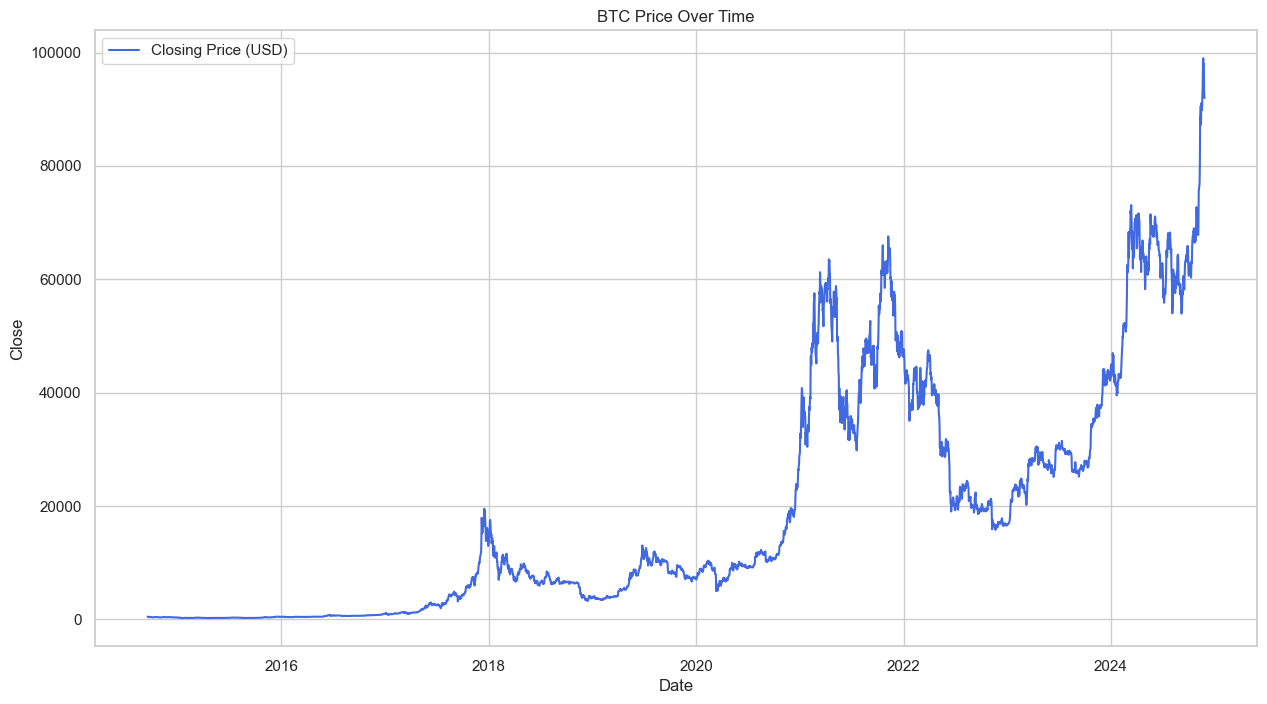

In [9]:
# Convert the `Date` to a datetime object for plotting
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)

# Plot the `Close` data
plt.figure(figsize=(15, 8))
sns.set_theme(style='whitegrid');
sns.lineplot(data=df, x='Date', y='Close', label='Closing Price (USD)', color='royalblue', linewidth=1.5);
plt.title('BTC Price Over Time');

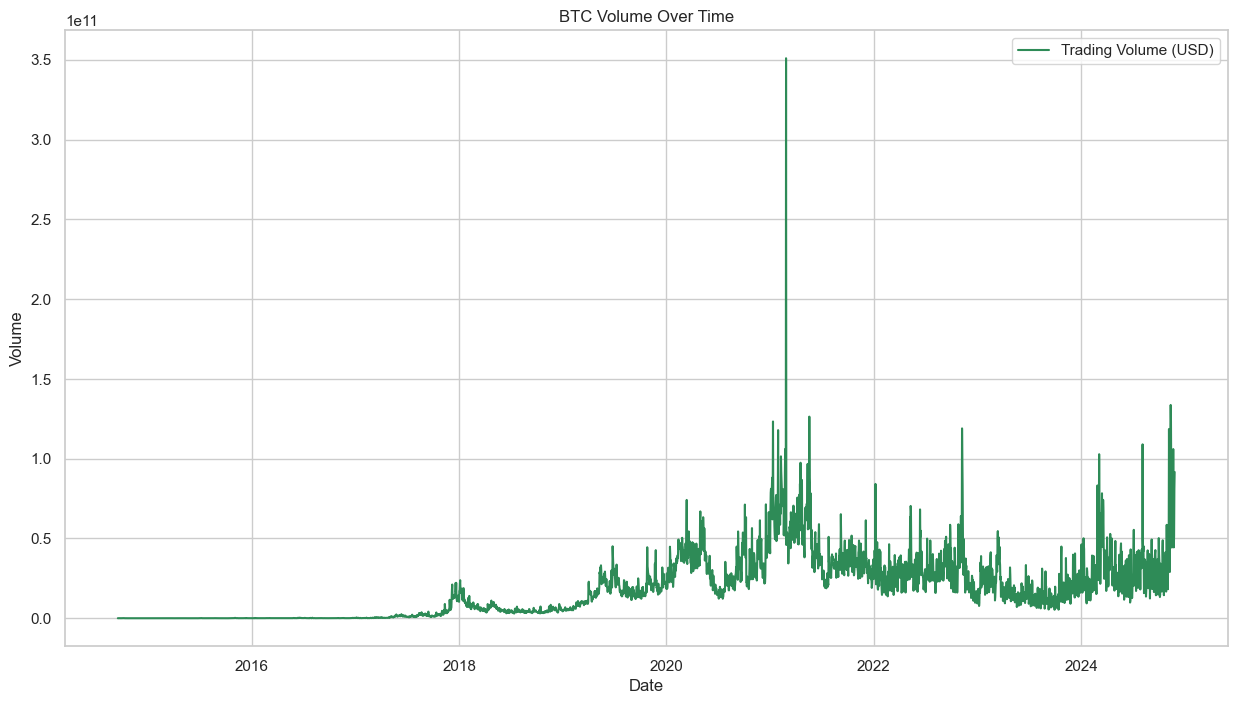

In [10]:
# Plot the `Volume` data
plt.figure(figsize=(15, 8))
sns.set_theme(style='whitegrid');
sns.lineplot(data=df, x='Date', y='Volume', label='Trading Volume (USD)', color='seagreen', linewidth=1.5);
plt.title('BTC Volume Over Time');

The most notable thing that stands out to me with these graphs is the massive spike in trade volume at some point in 2021. Just out of curiosity, let's take a closer look at this specific time period.

Date      2021-02-26 00:00:00+00:00
Close                  46339.761719
High                   48370.785156
Low                     44454.84375
Open                   47180.464844
Volume                 350967941479
Name: 2354, dtype: object

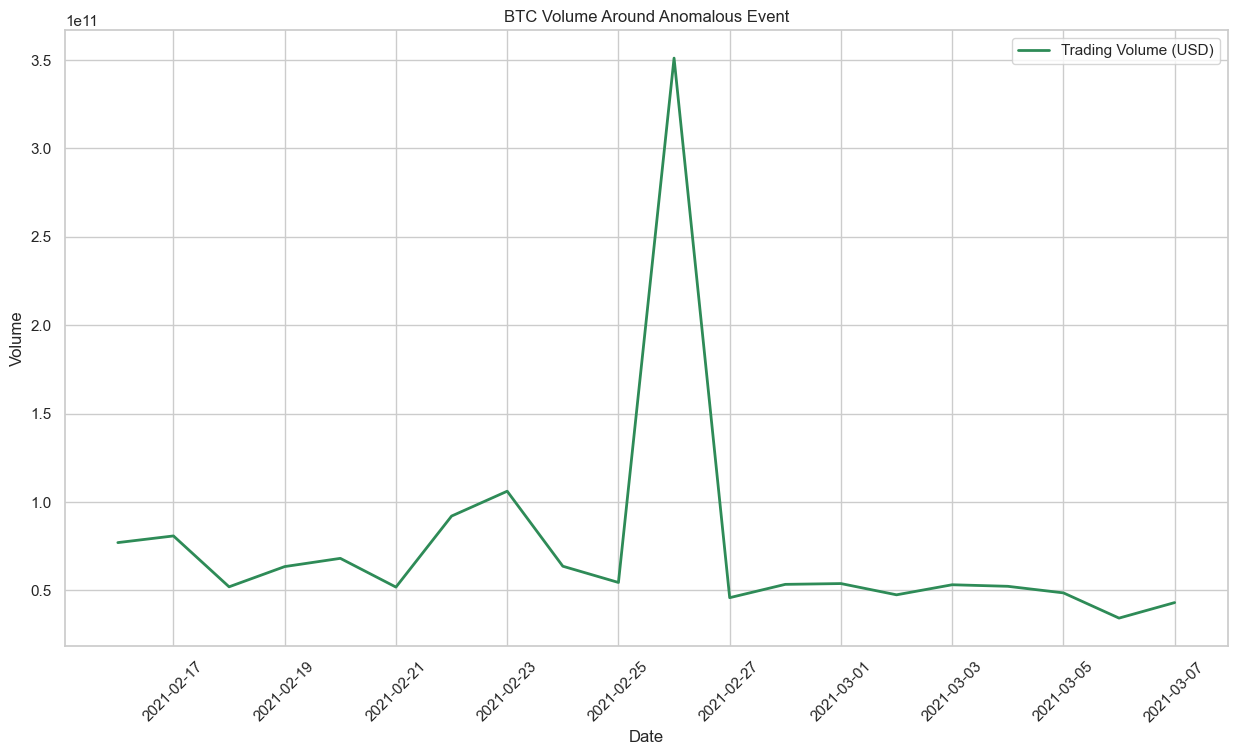

In [11]:
# Get the max `Volume` index
max_vol_idx = df['Volume'].idxmax()
display(df.iloc[max_vol_idx,:])
# Get the 10 days on either side of the anomalous event
df_zoomed_in = df.iloc[max_vol_idx-10:max_vol_idx+10,:]

# Plot the zoomed in frame
plt.figure(figsize=(15, 8))
sns.set_theme(style='whitegrid');
sns.lineplot(data=df_zoomed_in, x='Date', y='Volume', label='Trading Volume (USD)', color='seagreen', linewidth=2);
plt.title('BTC Volume Around Anomalous Event');
plt.xticks(rotation=45);

Interestingly, this massive jump in BTC trading volume came just one day after a "flash crash" in the price of US Treasury securities on February 25th, 2024. The goal of this project is not to perform a financial analysis; however this correlation is interesting and worth noting. Here are the [Fed Notes](https://www.federalreserve.gov/econres/notes/feds-notes/the-treasury-market-flash-event-of-february-25-2021-20210514.html#:~:text=On%20February%2025%2C%202021%2C%20there,recovering%20within%20about%20an%20hour.) on this market event.

#### Summary

In this EDA process, we took a look at the descriptive statistics of our dataset to get a high-level understanding of the dataset scale. Next, we looked at time-series graphs for both the `Close` and `Volume` features to get a better understanding of the long-term trends in the data. From a visual inspection we can see that there tend to be periods of relatively low `Close` price fluctuation up until about 2021—at which point the price starts to rise rapidly with several dramatic peaks and valleys. In the `Volume` graph we picked up on one particularly anomalous data point where the max volume spiked seemingly out of the blue. While it remains to be seen if this data point will be impactful on the forecasting models, it leads me to think that further development of this analysis could include other asset classes—most notable US Treasury Securities.

## Phase 2: Model Implementation

### Methodology

For the model training phase, we will start by implementing a Long Short-Term Memory RNN, and then compare it against a Gated Recurrent Unit. After both models have been implemented, we will take the better performing model and perform some hyperparameter tuning to see just how good we can get.

To get a handle on what needs to be done, I've walked through a few different tutorials (below) on time-series forecasting, LSTM, GRU and TensorFlow. At a high-level, the plan is:

1) Preprocess the data to get it into the correct shape for training. This will involve:

    a) scaling the data

    b) chunking the feature data into sequences using a sliding window and correlating these windows with the appropriate target value (next day `Close`)

    c) split the data into train and test
    
2) Build and fit the model with a small generic architecture
3) Make predictions on test data
4) Invert the scaled predictions and calculate performance metrics
5) Tune the hyperparameters to attempt to improve the model

[Analytics Vidhya Tutorial 1](https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/)

[ML Mastery Tutorial 2](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

[TensorFlow Docs Tutorial 3](https://www.tensorflow.org/tutorials/structured_data/time_series)

[Toward Data Science Tutorial 4](https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915)

### Preprocessing

For the LSTM to work appropriately, we need to get the dataset into a 3d structure with each matrix 'slice' of the 3d tensor representing a 'look-back' window that the LSTM cell will use to predict the target `y` value—the next day `Close`.

In [12]:
# Index on the `Date` to maintain time-series order and remove feature from dataset
df.set_index('Date', inplace=True)
df.head(10)

,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17 00:00:00+00:00,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18 00:00:00+00:00,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19 00:00:00+00:00,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20 00:00:00+00:00,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21 00:00:00+00:00,398.821014,412.425995,393.181000,408.084991,26580100
2014-09-22 00:00:00+00:00,402.152008,406.915985,397.130005,399.100006,24127600
2014-09-23 00:00:00+00:00,435.790985,441.557007,396.196991,402.092010,45099500
2014-09-24 00:00:00+00:00,423.204987,436.112000,421.131989,435.751007,30627700
2014-09-25 00:00:00+00:00,411.574005,423.519989,409.467987,423.156006,26814400


In [13]:
# Extract features and target from dataset
# From ISLR p. 427: in time-series forecasting the response variable is also a predictor
# We leave `Close` as a feature because we need it to predict the next day `Close`
# Convert all features to 2d numpy array
data = df.values
# Save col index of target for tracking in pre/post processing
target_idx = df.columns.get_loc('Close')

In [14]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
print(scaled_data[:5])

[[2.82566544e-03 2.57877402e-03 2.89416863e-03 2.92388408e-03
  4.31449241e-05]
 [2.49279599e-03 2.46500092e-03 2.48908482e-03 2.83277771e-03
  8.14009147e-05]
 [2.19281477e-03 2.17312750e-03 2.19471449e-03 2.50132936e-03
  9.11925723e-05]
 [2.33558004e-03 2.12748360e-03 2.24984437e-03 2.20354490e-03
  8.81834148e-05]
 [2.23354582e-03 2.01817564e-03 2.28382292e-03 2.33925276e-03
  5.88825241e-05]]


In [15]:
# From ISLR p. 428: extract many short mini-series of input sequences
# with a predefined length L (lag)

# Function for building sliding window sequences for model input/prediction
def build_dataset(data, target_idx, lag=30):
    X, y = [], []
    for i in range(len(data) - lag):
        # This will be one sequential prediction "chunk" 
        X.append(data[i:(i + lag)])
        # We want to predict the `Close` value one day after window
        y.append(data[(lag + i), target_idx])
    return np.array(X), np.array(y)

In [16]:
# Build the sliding window modified dataset
X, y = build_dataset(scaled_data, target_idx)

# Note: X is a 3d array—essentially an array of rolling 30-day feature time slices
# can be visualized as a cube with each slice matrix of size (window x features)
print(X.shape)
print(y.shape)

(3694, 30, 5)
(3694,)


In [17]:
# Split into training and test
# 80% train and 20% test
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2955, 30, 5)
(739, 30, 5)
(2955,)
(739,)


### Build the LSTM model

For this initial LSTM implementation we will build a simple model with:
* an input layer with 64 neurons
* a hidden layer with 32 neurons
* an output layer with 1 neuron that will provide the prediction

We'll keep the architecture for this first model simple to get an understanding of baseline performance. We will play around with more complex design decisions in the tuning phase.

In [18]:
model_lstm = Sequential()
# Input shape is size of each window matrix (window x features)
# TensorFlow tutorial: return_sequences=True returns for each time step vs. False only final time step
model_lstm.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
# Don't return the prediction until final time step for second layer
model_lstm.add(LSTM(32, return_sequences=False))
model_lstm.add(Dense(1))

# From lecture: if unsure what to use—try Adam
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_lstm.summary()

2025-01-16 14:46:28.326241: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-01-16 14:46:28.326274: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-01-16 14:46:28.326279: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-01-16 14:46:28.326556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-16 14:46:28.326582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Fit the model with 8 epochs (small number to start)
# Use MSE loss because this is what all the tutorials use (and the ISLR lab)
# Note: training locally leveraging M3 Max GPUs
history_lstm = model_lstm.fit(X_train, y_train, batch_size=16, epochs=8, verbose=1);

Epoch 1/8


2025-01-16 14:46:28.908506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0031
Epoch 2/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.2297e-04
Epoch 3/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.6560e-04
Epoch 4/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.2189e-04
Epoch 5/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.9960e-04
Epoch 6/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.8981e-04
Epoch 7/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.8361e-04
Epoch 8/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.7856e-04


In [20]:
yp_test_lstm = model_lstm.predict(X_test)
print(yp_test_lstm.shape)
print(y_test.shape)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(739, 1)
(739,)


In [21]:
# Scaler is built on full dataset so need to get predictions in same shape to invert
def reshape_dataset(pred, num_features, target_idx):
    # Create dummy array with same shape as originally scaled data (add dummy feature cols)
    dummy = np.zeros((len(pred), num_features))
    # Insert the pred data in the correct column
    dummy[:,target_idx] = pred.reshape(-1)   # predictions returned in column
    return dummy

In [22]:
# GLOBAL 
# For use in all models
# Convert the normalized test data back to original prices
inv_y_test = scaler.inverse_transform(reshape_dataset(y_test, data.shape[1], target_idx))[:, target_idx]

In [23]:
# Convert the normalized predictions to prices
inv_yp_test_lstm = scaler.inverse_transform(reshape_dataset(yp_test_lstm, data.shape[1], target_idx))[:, target_idx]

mse_lstm = mean_squared_error(inv_y_test, inv_yp_test_lstm)
mae_lstm = mean_absolute_error(inv_y_test, inv_yp_test_lstm)
rmse_lstm = np.sqrt(mse_lstm)

print(f'LSTM MAE::: {mae_lstm}')
print(f'LSTM RMSE::: {rmse_lstm}')

LSTM MAE::: 1221.708055499943
LSTM RMSE::: 1765.0992487615183


In [24]:
# Calculate baseline persistence forecast that just predicts previous day close
baseline_preds = np.roll(inv_y_test, 1)
mse_base = mean_squared_error(inv_y_test[1:], baseline_preds[1:])
mae_base = mean_absolute_error(inv_y_test[1:], baseline_preds[1:])
rmse_base = np.sqrt(mse_base)

print(f'Persistence MAE::: {mae_base}')
print(f'Persistence RMSE::: {rmse_base}')

Persistence MAE::: 806.5293418656843
Persistence RMSE::: 1299.1098402616592


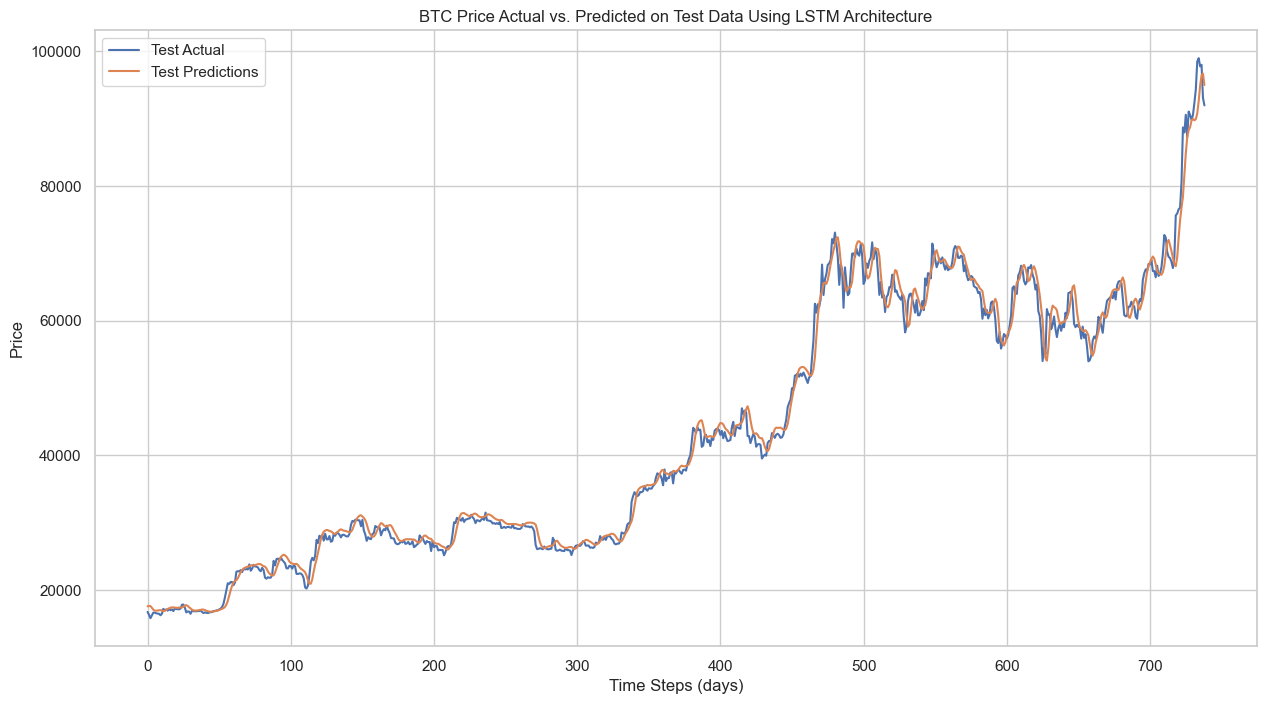

In [25]:
# Plot the LSTM actual vs. predicted price on test data
plt.figure(figsize=(15, 8))
plt.plot(inv_y_test, label='Test Actual')
plt.plot(inv_yp_test_lstm, label='Test Predictions')
plt.title('BTC Price Actual vs. Predicted on Test Data Using LSTM Architecture')
plt.xlabel('Time Steps (days)')
plt.ylabel('Price')
plt.legend()
plt.show()

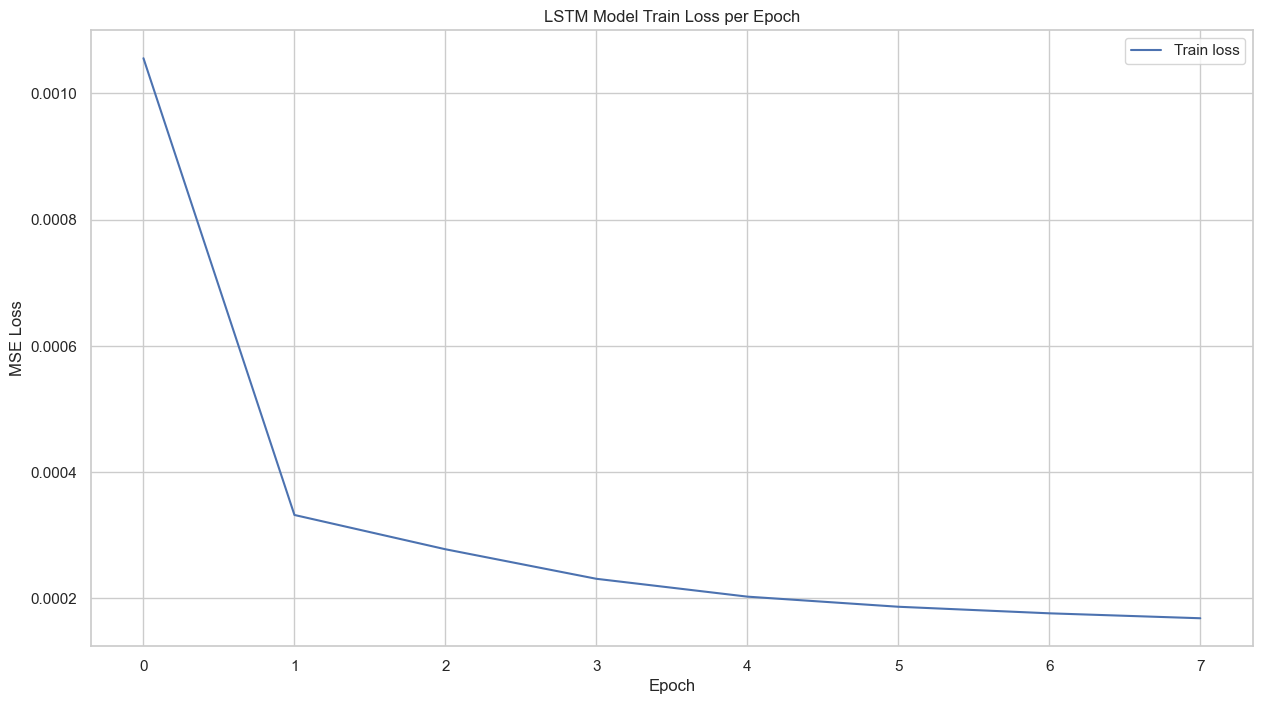

In [26]:
# Plot the LSTM MSE loss by epoch
plt.figure(figsize=(15, 8))
plt.plot(history_lstm.history['loss'], label='Train loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.title('LSTM Model Train Loss per Epoch')
plt.legend()
plt.show()

### LSTM Initial Results

As we can see above, this very simple implementation of an LSTM works! We get an MAE of 1262 and an RMSE of 1299 (changes slightly with each run). Unfortunately though, despite all that work, this is still far worse than simply predicting the previous day close which has an MAE of 806 and RMSE of 1299.

Let's see if we can do better with the GRU model.

### Build the GRU model

For this initial GRU model we will mirror the architecture and parameters of the LSTM model to get the best apples-to-apples comparison we can. Since all of the design decisions for this model are virtually the same, I will do this implementation in a more concise format.

In [27]:
model_gru = Sequential()
model_gru.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32, return_sequences=False))
model_gru.add(Dense(1))
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,073 (90.13 KB)

 Trainable params: 23,073 (90.13 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_gru = model_gru.fit(X_train, y_train, batch_size=16, epochs=8, verbose=1);

Epoch 1/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0096
Epoch 2/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.7557e-04
Epoch 3/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4988e-04
Epoch 4/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4527e-04
Epoch 5/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4197e-04
Epoch 6/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3980e-04
Epoch 7/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3757e-04
Epoch 8/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3524e-04


In [29]:
yp_test_gru = model_gru.predict(X_test)
print(yp_test_gru.shape)
print(y_test.shape)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(739, 1)
(739,)


In [30]:
inv_yp_test_gru = scaler.inverse_transform(reshape_dataset(yp_test_gru, data.shape[1], target_idx))[:, target_idx]

mse_gru = mean_squared_error(inv_y_test, inv_yp_test_gru)
mae_gru = mean_absolute_error(inv_y_test, inv_yp_test_gru)
rmse_gru = np.sqrt(mse_gru)

print(f'GRU MAE::: {mae_gru}')
print(f'GRU RMSE::: {rmse_gru}')

GRU MAE::: 989.6469584399335
GRU RMSE::: 1429.6042933099568


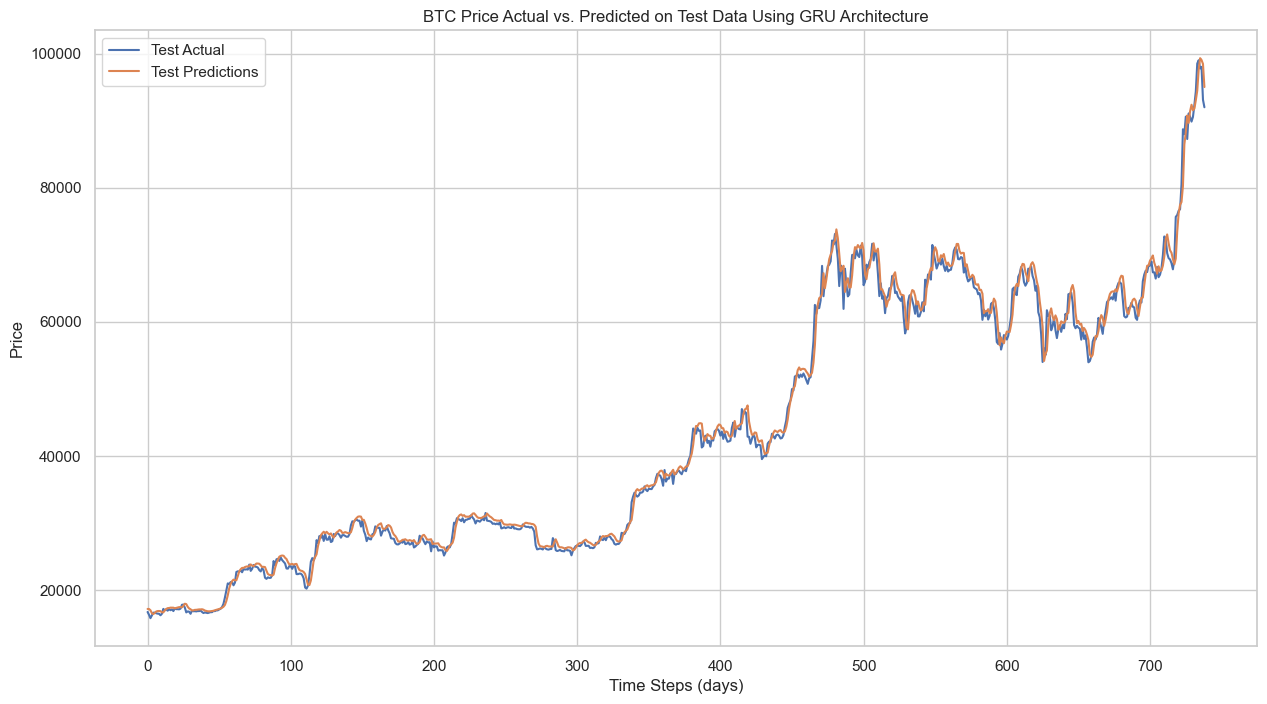

In [31]:
# Plot the GRU actual vs. predicted price on test data
plt.figure(figsize=(15, 8))
plt.plot(inv_y_test, label='Test Actual')
plt.plot(inv_yp_test_gru, label='Test Predictions')
plt.title('BTC Price Actual vs. Predicted on Test Data Using GRU Architecture')
plt.xlabel('Time Steps (days)')
plt.ylabel('Price')
plt.legend()
plt.show()

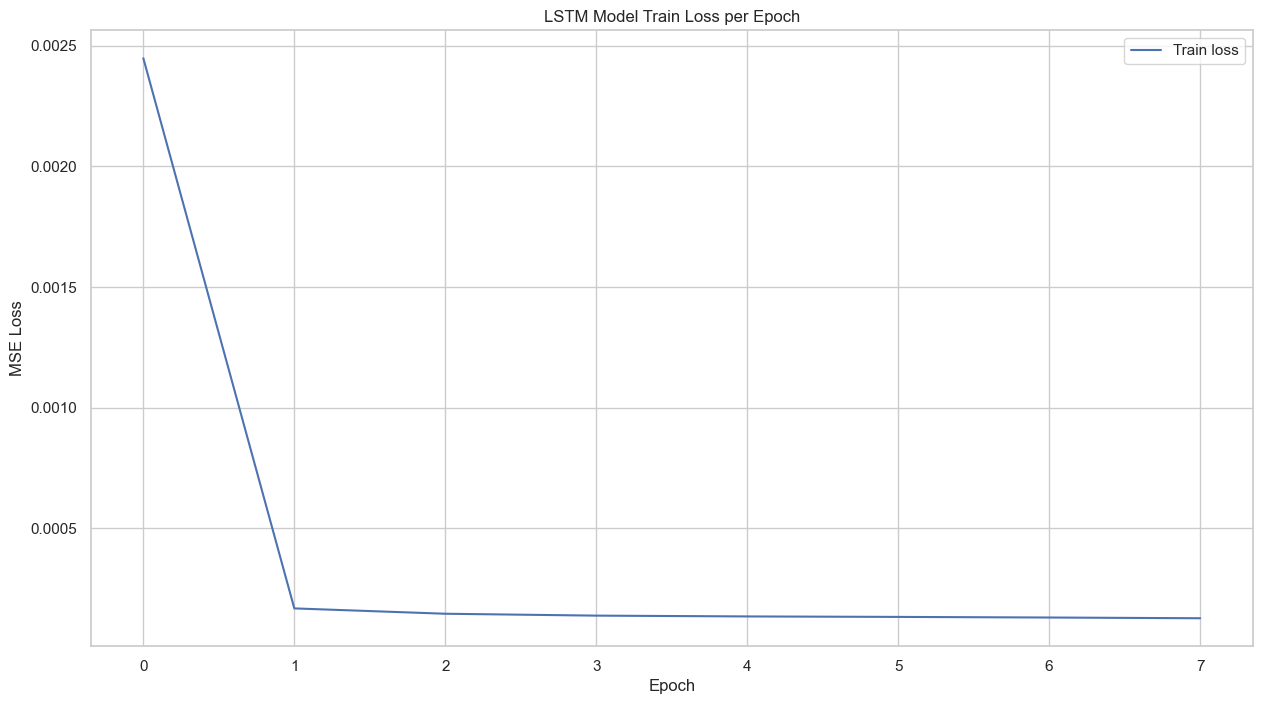

In [32]:
# Plot the GRU MSE loss by epoch
plt.figure(figsize=(15, 8))
plt.plot(history_gru.history['loss'], label='Train loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.title('LSTM Model Train Loss per Epoch')
plt.legend()
plt.show()

### GRU Initial Results

Wow! As we can see from the graph and metrics above the GRU model actually does better than the LSTM model under the same architecture. This is surprising since my hypothesis would have been that predicting stock market prices is inherently complex and therefore the more complex LSTM model would be better at capturing this complexity. Although, in thinking about it now, the real world market dynamics are inherently complex (there are billion dollar companies built on predicting them [Renaissance Technologies](https://en.wikipedia.org/wiki/Renaissance_Technologies)), but this dataset is actually not that complicated—it only has 5 features and 4 of those are almost perfectly correlated. So in that light, it makes more sense why the simpler GRU model would do better.

My hypothesis is shifting to the idea that maybe less complexity in the model is better.

### Model Tuning

Alright now that we've compared the models, lets take the best one and see if we can push the performance and beat persistence. Because there are so many changes that are possible to make, I'm going to documents the changes I test in a table below and then only report out on the best model at the end.

#### Change Log

Baseline GRU MAE: 910.77

Baseline GRU RMSE: 1356.65

Persistence MAE: 806.52

Persistence RMSE: 1299.10

| Modification | Reasoning | MAE | RMSE | Result |
|--------------|-----------|-----|------|--------|
| Add an additional layer | May capture more complexity | 1011.815 | 1586.849 | Worse |
| Increase # of units | May capture more complexity | 1063.05 | 1441.03 | Worse |
| Remove a layer | Reduce overfitting | 821.87 | 1308.18 | Better |
| Keep removed layer and decrease # of units | Reduce overfitting | 980.93 | 1488.09 | Worse |
| Keep removed layer and increase # of units | May capture a different pattern in data | 934.81 | 1427.40 | Worse |
| Increase batch size | Reduce noise | 998.55 | 1577.10 | Worse |
| Decrease batch size | Add more noise | 833.388 | 1337.62 | Better |
| Increase lag window size | Capture more long-term trends | 821.46 | 1292.68 | Best!!! |

Beat Persistence RMSE!
Current Persistence beating architecture/params:
```
lag=45
model_gru_opt.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model_gru_opt.add(GRU(64, return_sequences=False))
model_gru_opt.add(Dense(1))
model_gru_opt.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history_gru_opt = model_gru_opt.fit(X_train, y_train, batch_size=8, epochs=32, verbose=1);
```

In [33]:
# Rebuild dataset with longer lag window
X, y = build_dataset(scaled_data, target_idx, lag=45)
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [34]:
model_gru_opt = Sequential()
model_gru_opt.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model_gru_opt.add(GRU(64, return_sequences=False))
model_gru_opt.add(Dense(1))
model_gru_opt.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_gru_opt.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 64)             │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history_gru_opt = model_gru_opt.fit(X_train, y_train, batch_size=8, epochs=32, verbose=1);

Epoch 1/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0040
Epoch 2/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.0010e-04
Epoch 3/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.7565e-04
Epoch 4/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.5783e-04
Epoch 5/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.4775e-04
Epoch 6/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.4143e-04
Epoch 7/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.3684e-04
Epoch 8/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.3306e-04
Epoch 9/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.2967e-04
Epoch 10/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.2649e-04
Epoch 11/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.2351e-04
Epoch 12/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.2080e-04
Epoch 13/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.1843e-04
Epoch 14/32
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.1646e-04
Ep

In [36]:
# Recalculate inverse after changing window size
inv_y_test = scaler.inverse_transform(reshape_dataset(y_test, data.shape[1], target_idx))[:, target_idx]

In [37]:
yp_test_gru_opt = model_gru_opt.predict(X_test)
print(yp_test_gru_opt.shape)
print(y_test.shape)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(736, 1)
(736,)


In [38]:
inv_yp_test_gru_opt = scaler.inverse_transform(reshape_dataset(yp_test_gru_opt, data.shape[1], target_idx))[:, target_idx]

mse_gru_opt = mean_squared_error(inv_y_test, inv_yp_test_gru_opt)
mae_gru_opt = mean_absolute_error(inv_y_test, inv_yp_test_gru_opt)
rmse_gru_opt = np.sqrt(mse_gru_opt)

print(f'GRU_opt MAE::: {mae_gru_opt}')
print(f'GRU_opt RMSE::: {rmse_gru_opt}')

GRU_opt MAE::: 815.6996736178877
GRU_opt RMSE::: 1301.8082699202196


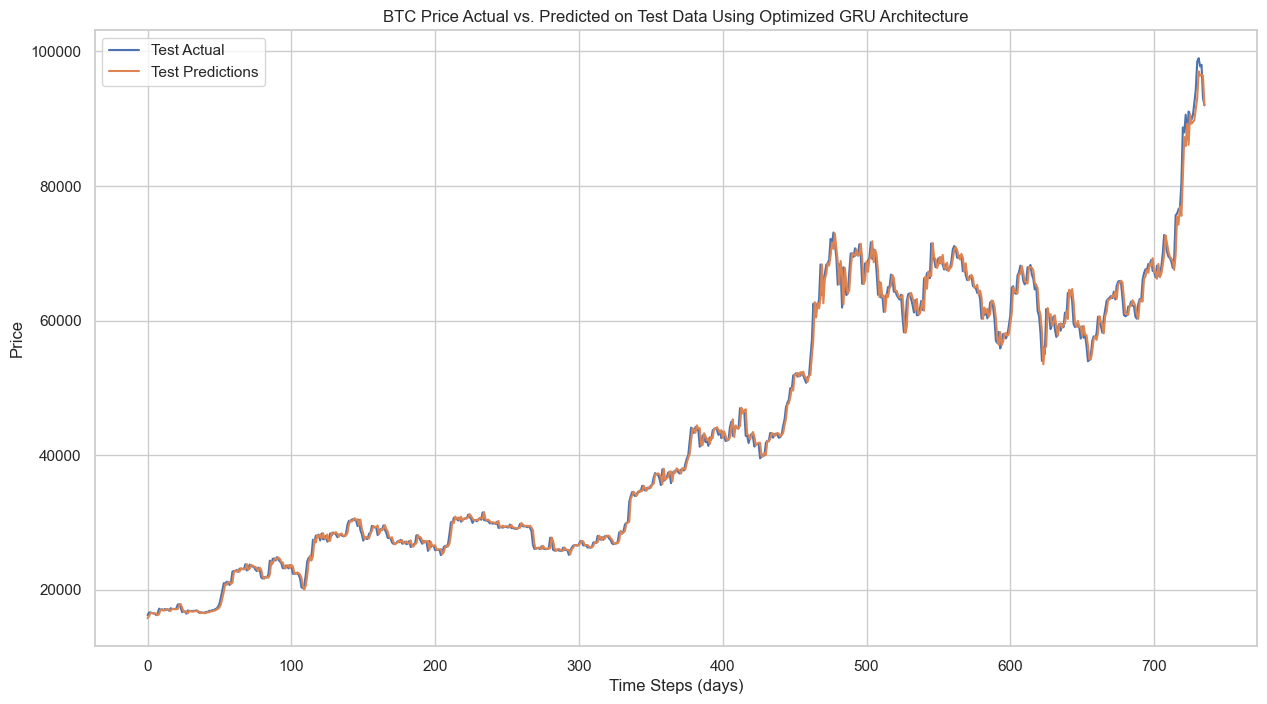

In [39]:
# Plot the GRU optimized actual vs. predicted price on test data
plt.figure(figsize=(15, 8))
plt.plot(inv_y_test, label='Test Actual')
plt.plot(inv_yp_test_gru_opt, label='Test Predictions')
plt.title('BTC Price Actual vs. Predicted on Test Data Using Optimized GRU Architecture')
plt.xlabel('Time Steps (days)')
plt.ylabel('Price')
plt.legend()
plt.show()

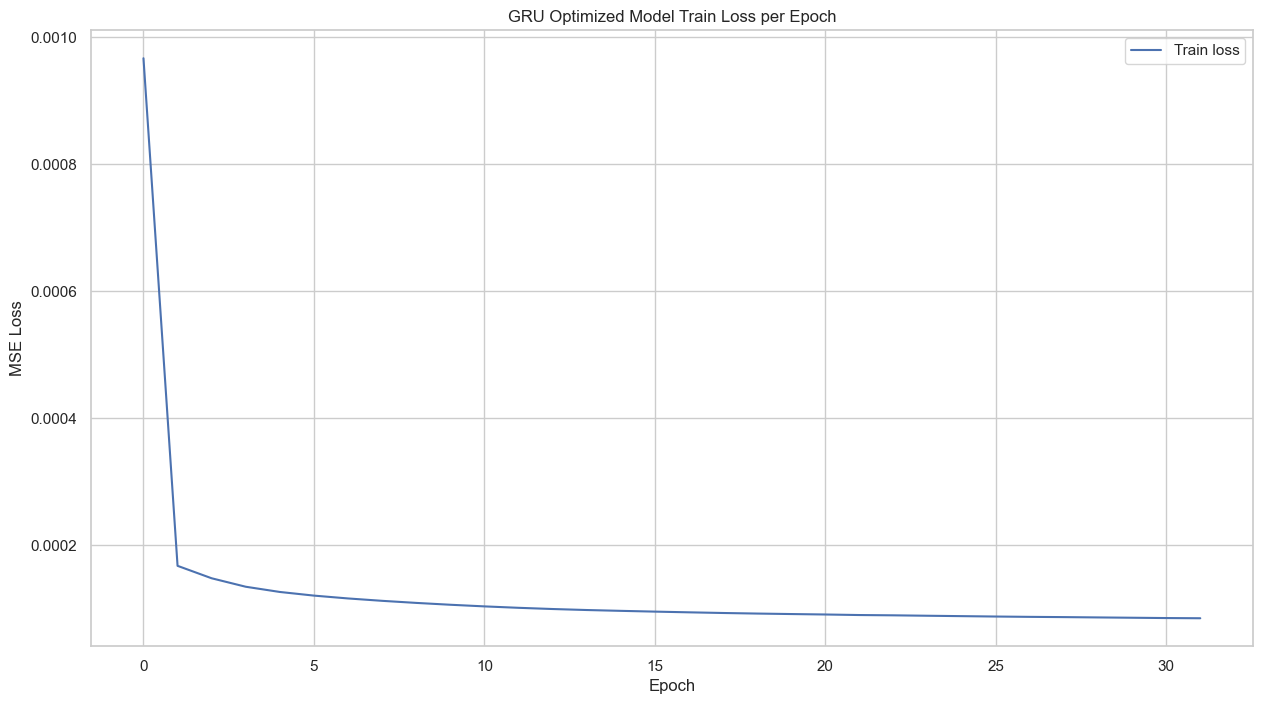

In [40]:
# Plot the GRU optimized MSE loss by epoch
plt.figure(figsize=(15, 8))
plt.plot(history_gru_opt.history['loss'], label='Train loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.title('GRU Optimized Model Train Loss per Epoch')
plt.legend()
plt.show()

## Results and Analysis

After comparing the LSTM and GRU models with the same architecture and hyperparmeters, we found that the GRU model performed best with the following initial results:

| Model | Metric | Result |
|-------|--------|--------|
| Naive Persistence | MAE | 806.53 |
| GRU | MAE | 872.67 |
| LSTM | MAE | 1260.60 |
| Naive Persistence | RMSE | 1299.11 |
| GRU | RMSE | 1351.69 |
| LSTM | RMSE | 1841.96 |

While I was initially shocked and disappointed that neither of these models beat the naive persistence model (simply predicts yesterday's close for today), after a bit of research I realized that in highly efficient markets like stocks (and in this case currency), consistently beating the persistence model is actually non-trivial. This gave me a bit of hope!

From here, I went into testing different architectures and hyperparameter settings. I tried to be as methodical about this as possible—only changing one variable at a time. At this point it became evident that the time I spent setting up access to my M3 Max GPUs was worth it as I was able to iterate fairly quickly on different architecture/hyperparameter combinations. Ultimately I came across a combination that was able to consistently beat the naive persistence model on RMSE! This mostly felt like luck from a very rough guess and check process, but it still felt great after the initial disappoint I had when falling short of this insanely simple model.

Here is the best model architecture and results:
```
lag=45
model_gru_opt.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model_gru_opt.add(GRU(64, return_sequences=False))
model_gru_opt.add(Dense(1))
model_gru_opt.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history_gru_opt = model_gru_opt.fit(X_train, y_train, batch_size=8, epochs=32, verbose=1);
```
| Model | Metric | Result |
|-------|--------|--------|
| GRU_opt | MAE | 817.14 |
| GRU_opt | RMSE | 1294.84 |

Note: due to the parallel processing in GPUs, even with the tf random seed, we still get slight variations in the evaluation metrics.

## Conclusion

Whoa. This project ended up being far more difficult—but also rewarding—than I initially thought it would be. From getting setup to run locally, to managing the data shape for the models—this ended up being far more challenging than I anticipated.

I'm happy with what I was able to accomplish, but it also opened the door to so many potential improvements/extensions that could be added. One of the first things I would do to improve this project is make everything much DRY-er. In the interest of time, I ended up just repeating a lot of code that should have been in a classes or functions. After looking over the TensorFlow tutorial, I realize I have a long way to go in terms of tight, clean code.

Aside from this, the next thing I want to do is extend this model to make multi-step predictions—with the ideal case of getting to a point that the model can look 30-days out. From here I want to figure out how to extend this beyond the test data to actually make predictions into the unseen future. I think it would be so cool to place some actual bets on the predictions of this model and score the results!